<a href="https://colab.research.google.com/github/skhabiri/DS-Unit-4-Sprint-2-Neural-Networks/blob/main/module2-Train/LS_DS17_422_Train_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train ANN

## *Data Science U4S2M2*

Continue to use TensorFlow Keras & a sample of the [Quickdraw dataset](https://github.com/googlecreativelab/quickdraw-dataset) to build a sketch classification model. The dataset has been sampled to only 10 classes and 10000 observations per class. Build a baseline classification model then run a few experiments with different optimizers and learning rates. 

*Don't forgot to switch to GPU on Colab!*

### Write a function to load your data

Wrap yesterday's preprocessing steps into a function that returns four items:
* X_train
* y_train
* X_test
* y_test

Your function should accept a `path` to the data as a argument.

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import wget

In [5]:
def load_quickdraw10(path):
  wget.download(path)
  data = np.load('quickdraw10.npz')
  X = data['arr_0']
  y = data['arr_1']

  print(X.shape)
  print(y.shape)

  X, y = shuffle(X, y)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  
  return X_train, y_train, X_test, y_test

In [6]:
path = 'https://github.com/skhabiri/ML-ANN/raw/main/data/quickdraw10.npz'

X_train, y_train, X_test, y_test = load_quickdraw10(path)

(100000, 784)
(100000,)


In [7]:
%rm quickdraw10.npz

### Write a Model Function
Write a function called `create_model` which returns a compiled TensorFlow Keras Sequential Model suitable for classifying the QuickDraw-10 dataset. Include parameters for the following: 
* Learning Rate
* Optimizer

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import *

In [9]:
def create_model(optim, lr=0.01):
    """
    784+1 * 32+1 * 32+1 * 10
    optim: name of the optimizer. values: [Adadelta, Adagrad, Adam, Ftrl, SGD]
    """
    opt = optim(learning_rate=lr)
    model = Sequential(
        [
        #  784 inputs + 1 bias connect to 32 1st layer Hiddent neurons
        Dense(32, activation='relu', input_dim=784),
        #  32 1st-H-Neurons + 1 bias connected to 32 2'nd layer H-Neurons
        Dense(32, activation='relu'),
        #  32 2nd-H-neurons connect to 10 Output neurons
        Dense(10, activation='softmax')       
        ]
    )
    # sparse_categorical_crossentropy is for multilable classification with integer classes
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [10]:
def fit_param(param_lst, key, **kwargs):
    """
    This function fits a ANN created by create_model() while sweeping a parameter
    param_list: list of values for the parameter
    key: string key for the parameter. Values: "lr", "batch_size", "epochs", "optimizer"
    return: a dictionary with 
    {f"{par}_": [fitted model, fitted result],
    "key": key, "param_lst": param_lst}
    model_dict[f"{par}_"][0] is the model
    model_dict[f"{par}_"][1] is the fit result
    """

    # initialize **kwargs:
    (lr, batch, epoch, optimizer) = (0.01, 32, 25, Adam)

    param_dict = {"lr": lr, "batch_size": batch, 
                  "epochs": epoch, "optimizer": optimizer}
    model_dict={}
    model_dict["key"] = key
    model_dict["param_lst"] = param_lst
    for par in param_lst:
        param_dict[key] = par
        print(f"********* Fitting for {key}={param_dict[key]} *********")
        model_dict.setdefault(f"{par}_", [None, None])
        model_dict[f"{par}_"][0] = create_model(param_dict["optimizer"], param_dict["lr"])
        model_dict[f"{par}_"][1] = model_dict[f"{par}_"][0].fit(
            X_train, y_train,
            # Hyperparameters!
            epochs=param_dict["epochs"], 
            batch_size=param_dict["batch_size"], 
            validation_data=(X_test, y_test))
    
    return model_dict

In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def data_param(model_dict):
    """
    Returns a concatinated dataframe of the fitted results and 
    plots the validation accuracy and loss for different values of the parameter
    """
    results = []
    for par in model_dict["param_lst"]:
        results.append(model_dict[f"{par}_"][1])

    df_lst = []
    param_name = f"{model_dict['key']}_"
    
    for res, par in zip(results, model_dict["param_lst"]):
        df = pd.DataFrame.from_dict(res.history)
        df['epoch'] = df.index.values
        df[param_name] = f"{par}_"
        df_lst.append(df)

    df = pd.concat(df_lst, axis=0)
    df[param_name] = df[param_name].astype('str')
    
    return df

In [12]:
def viz_param(df_lst):
    for i, df in enumerate(df_lst):
        plt.figure(figsize=(15, 5*len(df_lst)))
        ax1 = plt.subplot(len(df_lst), 2, 2*i+1)
        sns.lineplot(x='epoch', y='val_accuracy', hue=df.columns[5], data=df, ax=ax1, legend='brief')
        ax1.legend(bbox_to_anchor=(1, 1), loc=4)
        ax2 = plt.subplot(len(df_lst), 2, 2*i+2)
        sns.lineplot(x='epoch', y='val_loss', hue=df.columns[5], data=df, ax=ax2, legend='brief')
        ax2.legend(bbox_to_anchor=(1, 1), loc=4)
        plt.show()
    return      

In [13]:
batch_lst = [8, 32, 128, 512, 1024]
lr_lst = [0.0001, 0.001, 0.01, 0.1, 0.75, 1]
opt_lst = [Adadelta, Adagrad, Adam, Ftrl, SGD]

params_dic = { 
    "optimizer": [opt_lst, None, None, {"lr":0.001, "batch":128, "epoch":50, "optimizer":Adam}],
    "batch_size": [batch_lst, None, None, {"lr":0.001, "batch":32, "epoch":50, "optimizer":Adam}],
              "lr": [lr_lst, None, None, {"lr":0.01, "batch":128, "epoch":50, "optimizer":Adam}],
             }
df_lst = []

for key, val in params_dic.items():
    
    kwargs = params_dic[key][3]

    # create model
    params_dic[key][1] = fit_param(params_dic[key][0], key, **kwargs)

    # create dataframe
    params_dic[key][2] = data_param(params_dic[key][1])

    # append to df_lst
    df_lst.append(params_dic[key][2])

********* Fitting for optimizer=<class 'tensorflow.python.keras.optimizer_v2.adadelta.Adadelta'> *********
Epoch 1/50
625/625 [==============================] - 1s 2ms/step - loss: 151.3053 - accuracy: 0.0930 - val_loss: 111.3727 - val_accuracy: 0.0902
Epoch 2/50
625/625 [==============================] - 1s 980us/step - loss: 102.3672 - accuracy: 0.0938 - val_loss: 78.7456 - val_accuracy: 0.0954
Epoch 3/50
625/625 [==============================] - 1s 1ms/step - loss: 74.4143 - accuracy: 0.0985 - val_loss: 61.2821 - val_accuracy: 0.1064
Epoch 4/50
625/625 [==============================] - 1s 1ms/step - loss: 58.6090 - accuracy: 0.1098 - val_loss: 50.9280 - val_accuracy: 0.1206
Epoch 5/50
625/625 [==============================] - 1s 958us/step - loss: 49.2766 - accuracy: 0.1263 - val_loss: 43.9898 - val_accuracy: 0.1345
Epoch 6/50
625/625 [==============================] - 1s 992us/step - loss: 42.7680 - accuracy: 0.1393 - val_loss: 38.9552 - val_accuracy: 0.1464
Epoch 7/50
625/625 [

In [14]:
id(model_batch), id(params_dic["batch_size"][1])

(4441528216, 140397555046944)

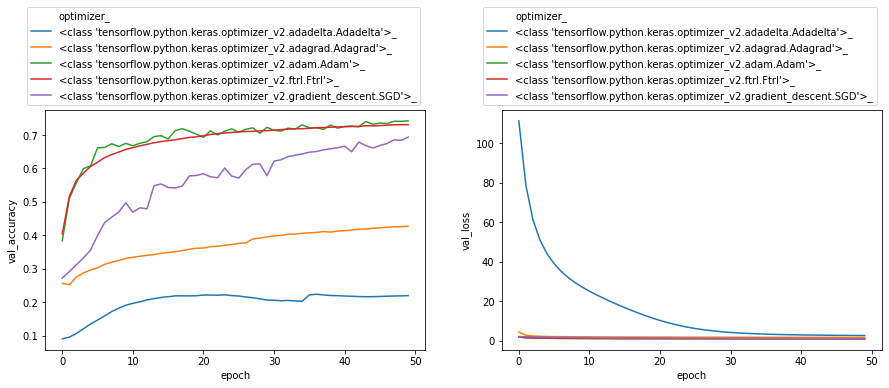

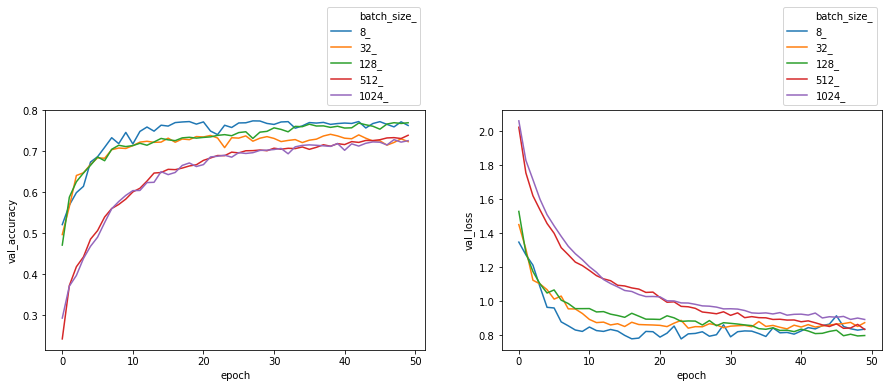

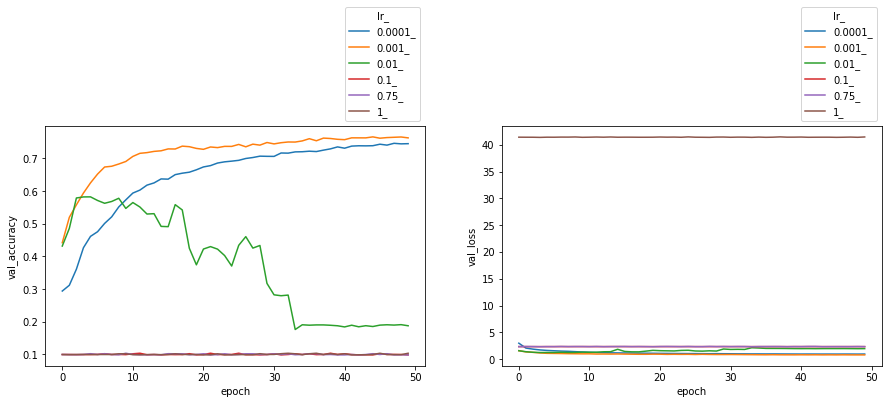

In [15]:
viz_param(df_lst)

* **Optimizers** For Quickdraw dataset, among opitizers Adam, SGD, and ftrl perform best.
* **Batch Size** smaller batch sizes are more noisy but but get us a better accuracy
* **Learning rate** 0.001 seems to be more effective. smaller learning rate underfit and bigger rates do not converge.

> *Seems like the entire X is divided into batches of size n and the NN is trained on each batch of n samples and W, b get's updated at the end of each batch of n. Once all batches in a training dataset are trained the epoch counter goes up and we create another set of batches randomly and exclusively (like Kfold) and retrain based on each of the new batches again. For stochastic GD, batch size is 1 and the accuracy of each update is low but number of updates are maximum, as the # of back propagation is maximum = "one back-propagation for each batch of each epoch.". That resuls in long computing time for each epoch. The training trend is very noise since the updates are done based on individual samples. 
In batch size GD, the number of batches is one and the size of the batch is equal to training set. Hence the epoch looks at the same entire training dataset repeatedly and make an update on every epoch run. Less noisy and minimum number of back propagation = one back-propagation per epoch. Hence runtime is faster per epoch. However need a large memory to process the entire dataset in one shot.*

In [16]:
class_names = ['apple',
 'anvil',
 'airplane',
 'banana',
 'The Eiffel Tower',
 'The Mona Lisa',
 'The Great Wall of China',
 'alarm clock',
 'ant',
 'asparagus']

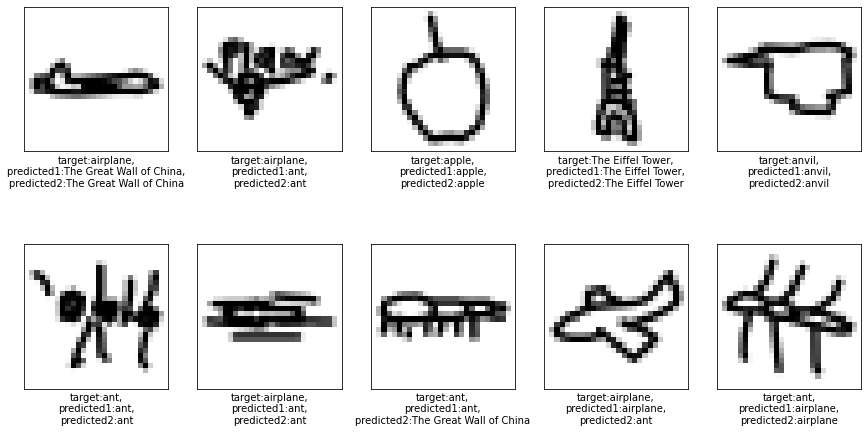

In [23]:
plt.figure(figsize=(15,8))
start = np.random.randint(0, len(X_test)-10)
i = 0
for num in range(start, start+10,1):
    plt.subplot(2,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[num].reshape(28,28), cmap=plt.cm.binary)
    
    predict1 = params_dic["lr"][1]['0.001_'][0].predict(X_test[num].reshape(1,784))
    predict2 = params_dic["batch_size"][1]["32_"][0].predict(X_test[num].reshape(1,784))
    predicted1 = class_names[predict1.argmax()]
    predicted2 = class_names[predict2.argmax()]
    plt.xlabel(f"target:{class_names[y_test[num]]},\npredicted1:{predicted1},\npredicted2:{predicted2}")
    i += 1
plt.show()

In [18]:
predict = params_dic["batch_size"][1]["32_"][0].predict(X_test[701].reshape(1,784))
class_names[predict.argmax()], class_names[y_test[701]]

('The Eiffel Tower', 'ant')

## Stretch Goals: 

- Implement GridSearch on anyone of the experiments
- On the learning rate experiments, implement [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
- Review material on the math behind gradient descent: 

  - Gradient Descent
    - Gradient Descent, Step-by-Step  by StatQuest w/ Josh Starmer. This will help you understand the gradient descent based optimization that happens underneath the hood of neural networks. It uses a non-neural network example, which I believe is a gentler introduction. You will hear me refer to this technique as "vanilla" gradient descent. 
    - Stochastic Gradient Descent, Clearly Explained!!! by StatQuest w/ Josh Starmer. This builds on the techniques in the previous video.  This technique is the one that is actually implemented inside modern 'nets. 
These are great resources to help you understand tomorrow's material at a deeper level. I highly recommend watching these ahead of tomorrow.

  - Background Math
    - Dot products and duality by 3Blue1Brown. Explains the core linear algebra operation happening in today's perceptron.
The paradox of the derivative by 3Blue1Brown. Does a great job explaining a derivative. 
    - Visualizing the chain rule and product rule by 3Blue1Brown. Explains the black magic that happens within Stochastic Gradient Descent. 
These math resources are very much optional. They can be very heady, but I encourage you to explore. Your understanding of neural networks will greatly increase if you understand this math background.


